In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import category_encoders as ce
import json
from pprint import pprint

In [2]:
df = pd.read_csv('data/merged4.csv', encoding='latin1', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Manually separating static and dynamic attributes
Also remove:
* **future data** = data that might be changed after end of a project's campaign or were not available at the time of the first scraping
* **redundant/duplicate data** = data contained in both datasets
* **useless data** = variables with single value (e.g. for all observations 'spotlight' is False), ids, names, json data, etc

In [3]:
df.info(max_cols=120)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 113 columns):
average_pledge                           30702 non-null float64
average_pledge_end                       30702 non-null float64
backers_count                            30702 non-null int64
backers_count_end                        30702 non-null int64
blurb                                    30702 non-null object
blurb_end                                30702 non-null object
category                                 30702 non-null object
category_end                             30702 non-null object
category_name                            30702 non-null object
category_name_end                        30702 non-null object
category_parent                          30702 non-null object
category_parent_end                      30702 non-null object
category_position                        30702 non-null int64
category_position_end                    30702 non-null int64
country   

In [4]:
static_data = []
dynamic_data = []
useless_data = []

### 1. average_pledge

In [5]:
dynamic_data.append('average_pledge')

### 2. average_pledge_end

In [6]:
# future data
useless_data.append('average_pledge_end')

### 3. backers_count

In [7]:
dynamic_data.append('backers_count')

### 4. backers_count_end

In [8]:
# future data
useless_data.append('backers_count_end')

### 5. blurb TODO NLP

In [9]:
static_data.append('blurb')

### 6. blurb_end

In [10]:
# future data
useless_data.append('blurb_end')

### 7. category

In [11]:
df.loc[1,'category']

'{"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/dance/performances"}},"color":10917369,"parent_id":6,"name":"Performances","id":254,"position":1,"slug":"dance/performances"}'

In [12]:
# wrong format, useful data already extracted
useless_data.append('category')

### 8. category_end

In [13]:
# future data
useless_data.append('category_end')

### 9. category_name

In [14]:
static_data.append('category_name')

### 10. category_name_end

In [15]:
# future data
useless_data.append('category_name_end')

### 11. category_parent

In [16]:
static_data.append('category_parent')

### 12. category_parent_end

In [17]:
# future data
useless_data.append('category_parent_end')

### 13. category_position (= position of category in parent category)

In [18]:
df.category_position.value_counts()

4     4103
3     3113
1     2833
2     2588
5     2559
7     2433
10    2024
6     1822
9     1693
14    1381
8     1360
11    1311
12     938
13     751
15     698
18     514
17     260
19     224
16      97
Name: category_position, dtype: int64

In [19]:
# cookbooks are 3rd in category Food (see kickstarter)
df[df.category_name == 'Cookbooks']['category_position'].value_counts()

3    184
Name: category_position, dtype: int64

In [20]:
# only Film & Video parent category contains 19 categories (19th is Webseries)
df[df.category_position == 19]['category_name'].value_counts()

Webseries    224
Name: category_name, dtype: int64

In [21]:
static_data.append('category_position')

### 14. category_position_end

In [22]:
# future data
useless_data.append('category_position_end')

### 15. country

In [23]:
static_data.append('country')

### 16. created_at

In [24]:
# timestamp, already used to extract days_preparation
# not commonly accesible to public on website, therefore should not affect behavior
useless_data.append('created_at')

### 17. creator

In [25]:
df.loc[1, 'creator']

'{"urls":{"web":{"user":"https://www.kickstarter.com/profile/1221271849"},"api":{"user":"https://api.kickstarter.com/v1/users/1221271849?signature=1446480213.130b2f9d9454277a259bf219e9b6dea39bf2ac2f"}},"name":"Cassandra Kemper","id":1221271849,"avatar":{"small":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=80&h=80&fit=crop&auto=format&q=92&s=2ed4c6c88ff74c2750dbdeae1d34b953","thumb":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=40&h=40&fit=crop&auto=format&q=92&s=fb2f0e15152b11832b8e80706ce01890","medium":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=160&h=160&fit=crop&auto=format&q=92&s=043c24006839e18fadfbe74e7a5769a4"}}'

In [26]:
# nothing usefull here, wrong format
useless_data.append('creator')

### 18. creator_end

In [27]:
# nothing usefull here, wrong format
useless_data.append('creator_end')

### 19. creator_name

In [28]:
# useless
useless_data.append('creator_name')

### 20. creator_name_end

In [29]:
# useless
useless_data.append('creator_name_end')

### 21. currency

In [30]:
static_data.append('currency')

### 22. currency_symbol

In [31]:
df.currency_symbol.value_counts()

$      23695
?       6308
kr       544
Fr       155
Name: currency_symbol, dtype: int64

In [32]:
# damaged and redundant data
useless_data.append('currency_symbol')

### 23. currency_trailing_code

In [33]:
# useless
useless_data.append('currency_trailing_code')

### 24. days_duration

In [34]:
static_data.append('days_duration')

### 25. days_preparation

In [35]:
static_data.append('days_preparation')

### 26. days_remaining

In [36]:
dynamic_data.append('days_remaining')

### 27. days_running

In [37]:
dynamic_data.append('days_running')

### 28. db_backers_count

In [38]:
# future data
useless_data.append('db_backers_count')

### 29. db_category_id

In [39]:
# useless (ordinal representation of parent category)
useless_data.append('db_category_id')

### 30. db_comments_count

In [40]:
# future data
useless_data.append('db_comments_count')

### 31. db_creators_url

In [41]:
useless_data.append('db_creators_url')

### 32. db_currency

In [42]:
# damaged redundant data
useless_data.append('db_currency')

### 33. db_description_full TODO NLP + img,video count?

In [43]:
static_data.append('db_description_full')

### 34. db_description_short

In [44]:
df[df['blurb_end'] != df['db_description_short']][['blurb','db_description_short']].sample(5)

,blurb,db_description_short
13095,Everything you wished Outlook would do: Docum...,Everything you wished Outlook would do: Docume...
30638,The Makers at LeapSpecies.Space will build off...,The Makers at LeapSpecies.Space will build off...
22005,We must forget everything.\nWe must pretend al...,We must forget everything.We must pretend all ...
3995,"L.A.'s best kept secret, Ate9 brings the bold ...","Now in it&#39;s 4th season, Ate9 continues to ..."
9131,"Take Only Photographs, Leave Only Footprints. ...","Take Only Photographs, Leave Only Footprints. ..."


In [45]:
# redundant data
useless_data.append('db_description_short')

### 35. db_duration

In [46]:
# keep due to inconsistency with days_duration
static_data.append('db_duration')

### 36. db_end_time

In [47]:
# useless
useless_data.append('db_end_time')

### 37. db_faq_count

In [48]:
# future data
useless_data.append('db_faq_count')

### 38. db_fb_comments_count

In [49]:
df['db_fb_comments_count'].describe()

count    30702.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: db_fb_comments_count, dtype: float64

In [50]:
# always 0
useless_data.append('db_fb_comments_count')

### 39. db_fb_shares_count TODO estimate

In [51]:
dynamic_data.append('db_fb_shares_count')

### 40. db_goal

In [52]:
len(df[df['goal'] != df['db_goal']])

0

In [53]:
# redundant data
useless_data.append('db_goal')

### 41. db_hours_remaining

In [54]:
# useless data
useless_data.append('db_hours_remaining')

### 42. db_image_url TODO transform

In [55]:
static_data.append('db_image_url')

### 43. db_location_id

In [56]:
len(df['db_location_id'].value_counts())

5139

In [57]:
# useless (ordinal representation of other columns)
useless_data.append('db_location_id')

### 44. db_name

In [58]:
# useless
useless_data.append('db_name')

### 45. db_pledged

In [59]:
# future data
useless_data.append('db_pledged')

### 46. db_project_data

In [60]:
row = 1
dict_data = json.loads(df.loc[row, 'db_project_data'])
#pprint(dict_data)

In [61]:
# usefull data already extracted
useless_data.append('db_project_data')

### 47. db_project_id

In [62]:
# useless
useless_data.append('db_project_id')

### 48. db_project_we_love

In [63]:
# future data
useless_data.append('db_project_we_love')

### 49. db_start_time

In [64]:
# useless
useless_data.append('db_start_time')

### 50. db_status

In [65]:
# useless, we use our own classes
useless_data.append('db_status')

### 51. db_subcategory_id

In [66]:
# ordinal representation of category_name
useless_data.append('db_subcategory_id')

### 52. db_updates_count

In [67]:
# future data
useless_data.append('db_updates_count')

### 53. db_url

In [68]:
# useless
useless_data.append('db_url')

### 54. db_video_url TODO transform

In [69]:
static_data.append('db_video_url')

### 55. deadline_end  TODO extract features (+ add analysis)

In [70]:
# already used to extract days_duration and days_remaining
static_data.append('deadline_end')

### 56. disable_communication

In [71]:
df['disable_communication'].describe()

count     30702
unique        1
top       False
freq      30702
Name: disable_communication, dtype: object

In [72]:
# always False
useless_data.append('disable_communication')

### 57. disable_communication_end

In [73]:
# future data
useless_data.append('disable_communication_end')

### 58. goal

In [74]:
static_data.append('goal')

### 59. id

In [75]:
# useless
useless_data.append('id')

### 60. launched_at  TODO extract features (+ add analysis)

In [76]:
# already used to extract days_preparation and days_running
static_data.append('launched_at')

### 61. location

In [77]:
# already used to extract data
useless_data.append('location')

### 62. location_end

In [78]:
# future data
useless_data.append('location_end')

### 63. location_is_root

In [79]:
df.location_is_root.describe()

count     30702
unique        1
top       False
freq      30702
Name: location_is_root, dtype: object

In [80]:
# always False
useless_data.append('location_is_root')

### 64. location_name

In [81]:
static_data.append('location_name')

### 65. location_name_end

In [82]:
# future data
useless_data.append('location_name_end')

### 66. location_state

In [83]:
static_data.append('location_state')

### 67. location_state_end

In [84]:
# future data
useless_data.append('location_state_end')

### 68. location_type

In [85]:
static_data.append('location_type')

### 69. location_type_end

In [86]:
# future data
useless_data.append('location_type_end')

### 70. name

In [87]:
# useless
useless_data.append('name')

### 71. name_end

In [88]:
# useless
useless_data.append('name_end')

### 72. photo

In [89]:
df.loc[1,'photo']

'{"small":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=160&h=120&fit=crop&auto=format&q=92&s=024364bb83f379e11d0ef29eafd2bb3a","1536x1152":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a","thumb":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=40&h=30&fit=crop&auto=format&q=92&s=5556d33ffad29a3ff8f0e676a0ebeaeb","1024x768":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1024&h=768&fit=crop&auto=format&q=92&s=0baef5145af0d44caaebdffcecad8709","med":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=266&h=200&fit=crop&auto=format&q=92&s=0e6f16d2bc45ce1925bc6661c340ced2","key":"projects/2137299/photo-original.jpg","ed":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=338&h=250&fit=crop&auto=format&q=92&s=f323d7eb379b5b563b9ef7e262fda6cd","fu

In [90]:
# wrong format, describes only 1 photo - redundant data
useless_data.append('photo')

### 73. photo_end

In [91]:
# useless, redundant
useless_data.append('photo_end')

### 74. pledged

In [92]:
dynamic_data.append('pledged')

### 75. pledged_end

In [93]:
# future data
useless_data.append('pledged_end')

### 76. profile

In [94]:
df.loc[1, 'profile']

'{"background_image_opacity":0.8,"link_text_color":null,"state_changed_at":1444938006,"should_show_feature_image":true,"blurb":null,"background_color":null,"project_id":2176873,"name":null,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a","baseball_card":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a"}},"link_url":null,"show_feature_image":false,"id":2176873,"state":"inactive","text_color":null,"link_text":null,"link_background_color":null}'

In [95]:
# wrong format, useless
useless_data.append('profile')

### 77. profile_end

In [96]:
# future data
useless_data.append('profile_end')

### 78. ratio_pledged_end_goal

In [97]:
# already used to extract class
useless_data.append('ratio_pledged_end_goal')

### 79. ratio_pledged_goal

In [98]:
dynamic_data.append('ratio_pledged_goal')

### 80. ratio_running_duration

In [99]:
dynamic_data.append('ratio_running_duration')

### 81. scraped_at

In [100]:
# already used to extract many features
useless_data.append('scraped_at')

### 82. slug

In [101]:
# useless
useless_data.append('slug')

### 83. source_url

In [102]:
# useless
useless_data.append('source_url')

### 84. source_url_end

In [103]:
# useless
useless_data.append('source_url_end')

### 85. spotlight

In [104]:
df.spotlight.describe()

count     30702
unique        1
top       False
freq      30702
Name: spotlight, dtype: object

In [105]:
# always False
useless_data.append('spotlight')

### 86. spotlight_end

In [106]:
# future data
useless_data.append('spotlight_end')

### 87. staff_pick

In [107]:
dynamic_data.append('staff_pick')

### 88. staff_pick_end

In [108]:
# future data
useless_data.append('staff_pick_end')

### 89. state

In [109]:
df.state.describe()

count     30702
unique        1
top        live
freq      30702
Name: state, dtype: object

In [110]:
# always live
useless_data.append('state')

### 90. state_changed_at

In [111]:
# useless
useless_data.append('state_changed_at')

### 91. state_changed_at_end

In [112]:
# useless, future data
useless_data.append('state_changed_at_end')

### 92. state_end

In [113]:
# future data, we have our own prediction class
useless_data.append('state_end')

### 93. static_usd_rate

In [114]:
# already used for currency conversion to USD
useless_data.append('static_usd_rate')

### 94. static_usd_rate_end

In [115]:
# useless, future data
useless_data.append('static_usd_rate_end')

### 95. url_name

In [116]:
# useless
useless_data.append('url_name')

### 96. urls

In [117]:
df.loc[1, 'urls']

'{"web":{"project":"https://www.kickstarter.com/projects/1221271849/all-style-dance-battle-the-streak?ref=category","rewards":"https://www.kickstarter.com/projects/1221271849/all-style-dance-battle-the-streak/rewards"}}'

In [118]:
# useless
useless_data.append('urls')

### 97. urls_end

In [119]:
# useless
useless_data.append('urls_end')

### 98. urls_url

In [120]:
# useless
useless_data.append('urls_url')

### 99. urls_url_end

In [121]:
# useless
useless_data.append('urls_url_end')

### 100. usd_goal

In [122]:
static_data.append('usd_goal')

### 101. usd_pledged

In [123]:
dynamic_data.append('usd_pledged')

### 102. usd_pledged_end

In [124]:
# future data
useless_data.append('usd_pledged_end')

### 103. class

In [125]:
# predicted class
static_data.append('class')

### 104. ID

In [126]:
# useless
useless_data.append('ID')

### 105. faq_count_while_scraping

In [127]:
dynamic_data.append('faq_count_while_scraping')

### 106. comments_count_creator_while_scraping

In [128]:
dynamic_data.append('comments_count_creator_while_scraping')

### 107. comments_count_public_while_scraping

In [129]:
dynamic_data.append('comments_count_public_while_scraping')

### 108. updates_count_while_scraping

In [130]:
dynamic_data.append('updates_count_while_scraping')

### 109. updates_likes_sum_while_scraping

In [131]:
dynamic_data.append('updates_likes_sum_while_scraping')

### 110. updates_likes_mean_while_scraping

In [132]:
dynamic_data.append('updates_likes_mean_while_scraping')

### 111. updates_likes_min_while_scraping

In [133]:
dynamic_data.append('updates_likes_min_while_scraping')

### 112. updates_likes_max_while_scraping

In [134]:
dynamic_data.append('updates_likes_max_while_scraping')

### 113. updates_likes_median_while_scraping

In [135]:
dynamic_data.append('updates_likes_median_while_scraping')

In [136]:
len(static_data)

20

In [137]:
len(dynamic_data)

19

In [138]:
len(useless_data)

74

In [139]:
static_data

['blurb',
 'category_name',
 'category_parent',
 'category_position',
 'country',
 'currency',
 'days_duration',
 'days_preparation',
 'db_description_full',
 'db_duration',
 'db_image_url',
 'db_video_url',
 'deadline_end',
 'goal',
 'launched_at',
 'location_name',
 'location_state',
 'location_type',
 'usd_goal',
 'class']

In [140]:
dynamic_data

['average_pledge',
 'backers_count',
 'days_remaining',
 'days_running',
 'db_fb_shares_count',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'staff_pick',
 'usd_pledged',
 'faq_count_while_scraping',
 'comments_count_creator_while_scraping',
 'comments_count_public_while_scraping',
 'updates_count_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_mean_while_scraping',
 'updates_likes_min_while_scraping',
 'updates_likes_max_while_scraping',
 'updates_likes_median_while_scraping']

In [141]:
df_selected = df.drop(useless_data, axis=1)

In [142]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 39 columns):
average_pledge                           30702 non-null float64
backers_count                            30702 non-null int64
blurb                                    30702 non-null object
category_name                            30702 non-null object
category_parent                          30702 non-null object
category_position                        30702 non-null int64
country                                  30702 non-null object
currency                                 30702 non-null object
days_duration                            30702 non-null int64
days_preparation                         30702 non-null int64
days_remaining                           30702 non-null int64
days_running                             30702 non-null int64
db_description_full                      30691 non-null object
db_duration                              30702 non-null int64
db_fb_shares_co

In [143]:
df_selected.to_csv('data/selected_data.csv')

# Data pre-processing

## Sampling

## Outlier detection

## Missing values resolution

In [144]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 20 columns):
blurb                  30702 non-null object
category_name          30702 non-null object
category_parent        30702 non-null object
category_position      30702 non-null int64
country                30702 non-null object
currency               30702 non-null object
days_duration          30702 non-null int64
days_preparation       30702 non-null int64
db_description_full    30691 non-null object
db_duration            30702 non-null int64
db_image_url           21414 non-null object
db_video_url           20443 non-null object
deadline_end           30702 non-null int64
goal                   30702 non-null float64
launched_at            30702 non-null int64
location_name          30702 non-null object
location_state         30695 non-null object
location_type          30702 non-null object
usd_goal               30702 non-null int64
class                  30702 non-null int6

In [145]:
df[df['location_state'].isnull()][['url_name', 'location_name', 'location_state', 'location_type', 'country']]

,url_name,location_name,location_state,location_type,country
3054,the-white-desert-wildlife-and-antarctica-photo...,Antarctica,NaN,Country,US
7903,music-video-makedonsko-devojce-jazz-version,Skopje,NaN,Town,DE
16683,oualichi-gold-caribbean-erotica,Philipsburg,NaN,Town,US
21286,new-album-kickstarter,Road Town,NaN,Town,US
30232,baby-chef-cookbook-and-app-with-healthy-recipe...,Skopje,NaN,Town,AU
30347,ninos-otomies-le-cantan-al-papa-francisco,Vatican City,NaN,Town,MX
30389,portraits-of-place-in-antarctica-ii,Antarctica,NaN,Country,US


In [146]:
df.loc[3054, 'location_state'] = 'None'
df.loc[7903, 'location_state'] = 'Macedonia'
df.loc[16683, 'location_state'] = 'Sint Maarten (Dutch part)'
df.loc[21286, 'location_state'] = 'Virgin Islands, U.S. '
df.loc[30232, 'location_state'] = 'Macedonia'
df.loc[30347, 'location_state'] = 'Vatican City'
df.loc[30389, 'location_state'] = 'None'

In [147]:
df[df['location_state'].isnull()][['url_name', 'location_name', 'location_state', 'location_type', 'country']]

,url_name,location_name,location_state,location_type,country


# Feature engineering

## Feature extraction

### 1. deadline

In [148]:
# convert unix timestamp to datetime of scraping
df['deadline_datetime'] = pd.to_datetime(df['deadline_end'], unit='s')
df[['url_name','deadline_end','deadline_datetime', 'db_end_time']].sample(5)

,url_name,deadline_end,deadline_datetime,db_end_time
13391,blue-lives-matter-usa-wooden-plaque,1471561207,2016-08-18 23:00:07,2016-08-18
18921,my-photography-art-website-setup-horizonphotog...,1482972396,2016-12-29 00:46:36,2016-12-28
9701,the-willow-consort-prague-tour-2016,1464361408,2016-05-27 15:03:28,2016-05-27
13118,mana-modular-new-way-to-build-your-dream-mixin...,1470243404,2016-08-03 16:56:44,2016-08-03
21468,best-of-commodore-amiga-demoscene-funding-2017,1491807475,2017-04-10 06:57:55,2017-04-10


#### 1.1 year

In [149]:
df['deadline_year'] = df['deadline_datetime'].dt.year

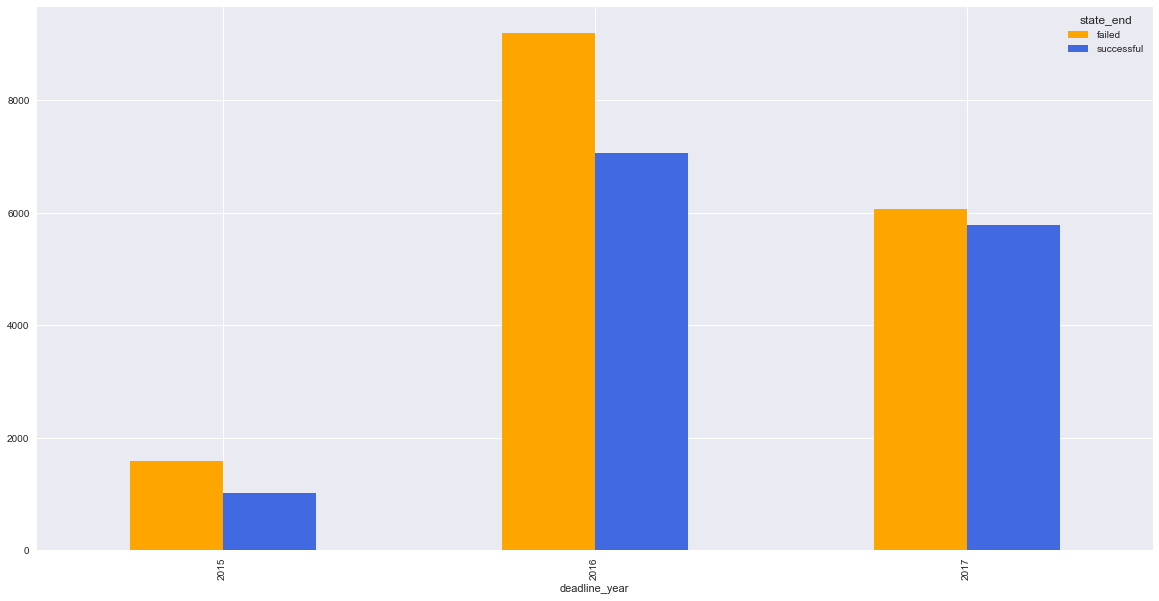

In [150]:
pd.crosstab(index=df['deadline_year'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.2 month

In [151]:
df['deadline_month'] = df['deadline_datetime'].dt.month

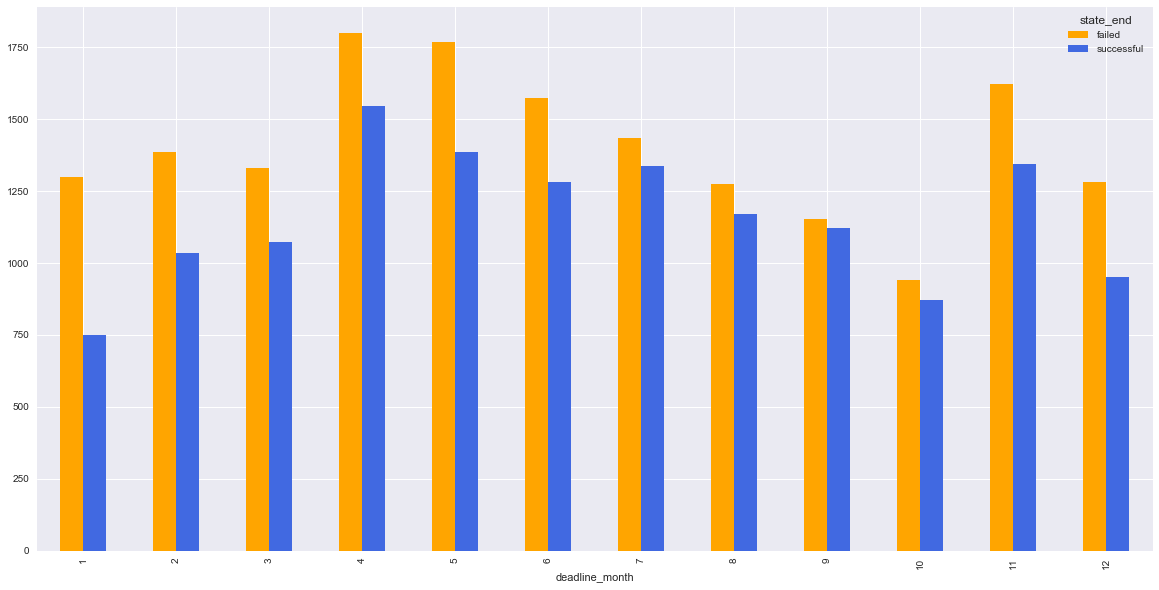

In [152]:
pd.crosstab(index=df['deadline_month'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.3 day

In [153]:
df['deadline_day'] = df['deadline_datetime'].dt.day

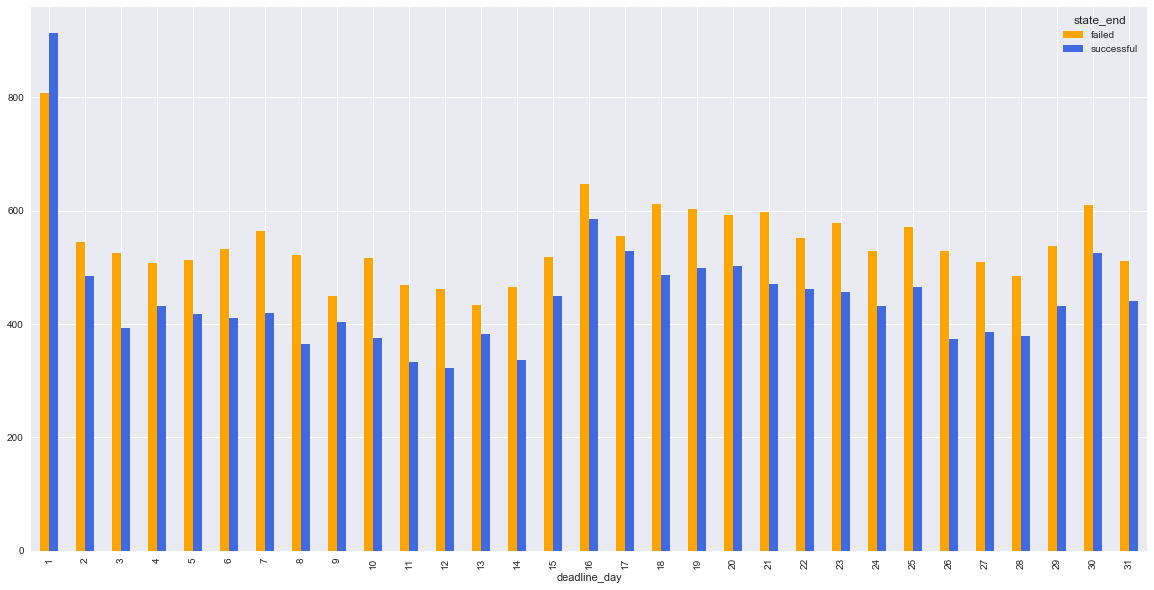

In [154]:
pd.crosstab(index=df['deadline_day'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.4 day of week

In [155]:
df['deadline_dayofweek'] = df['deadline_datetime'].dt.dayofweek

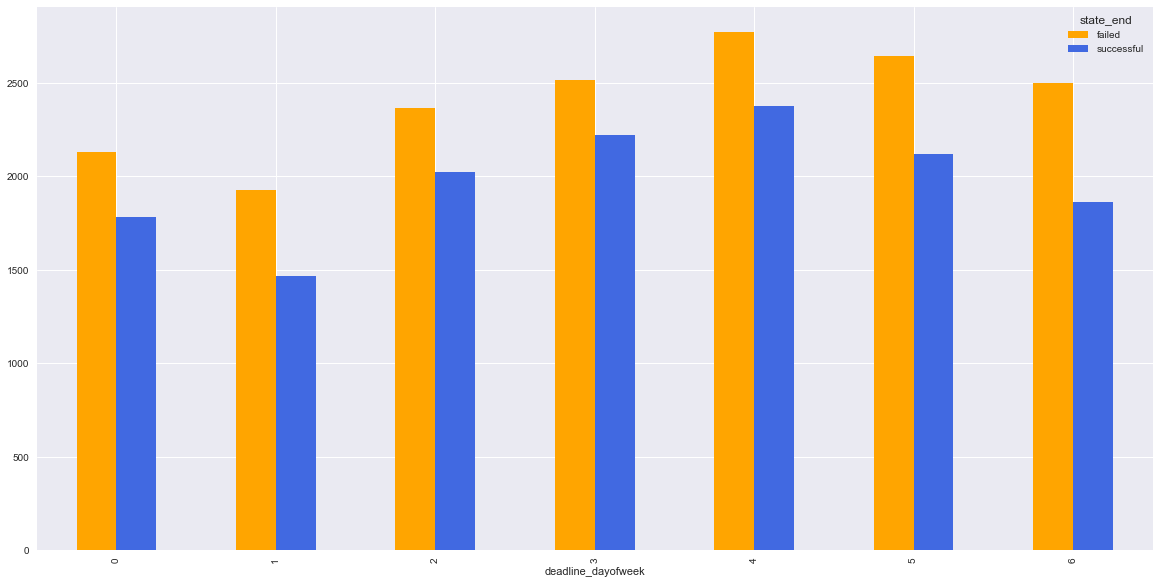

In [156]:
pd.crosstab(index=df['deadline_dayofweek'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.5 hour

In [157]:
df['deadline_hour'] = df['deadline_datetime'].dt.hour

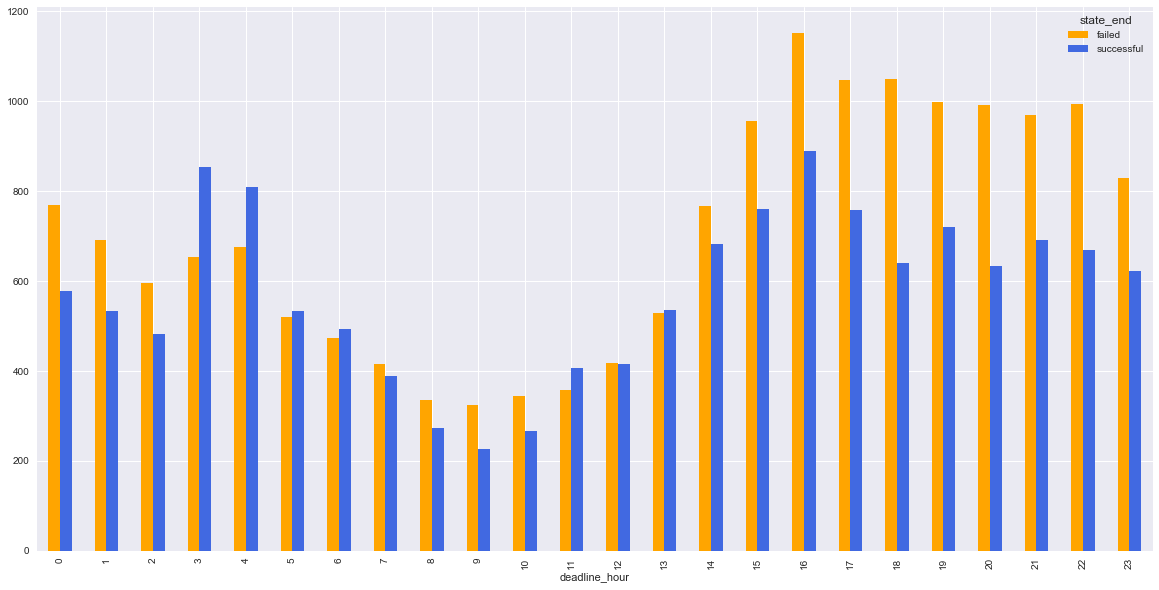

In [158]:
pd.crosstab(index=df['deadline_hour'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

### 2. start

In [159]:
# convert unix timestamp to datetime
df['launch_datetime'] = pd.to_datetime(df['launched_at'], unit='s')
df[['url_name','launched_at','launch_datetime', 'db_start_time']].sample(5)

,url_name,launched_at,launch_datetime,db_start_time
6076,bring-me-mishis-strudel,1456931788,2016-03-02 15:16:28,NaN
1341,tales-a-cautionary-story-about-heroin-addiction,1444510736,2015-10-10 20:58:56,2015-10-10
12988,angelarium-book-of-watchers,1467293380,2016-06-30 13:29:40,2016-06-30
13196,sky-reach-youth-space-initiative,1467139585,2016-06-28 18:46:25,NaN
27032,nocturne-2,1496598222,2017-06-04 17:43:42,2017-06-04


#### 2.1 year

In [160]:
df['launch_year'] = df['launch_datetime'].dt.year

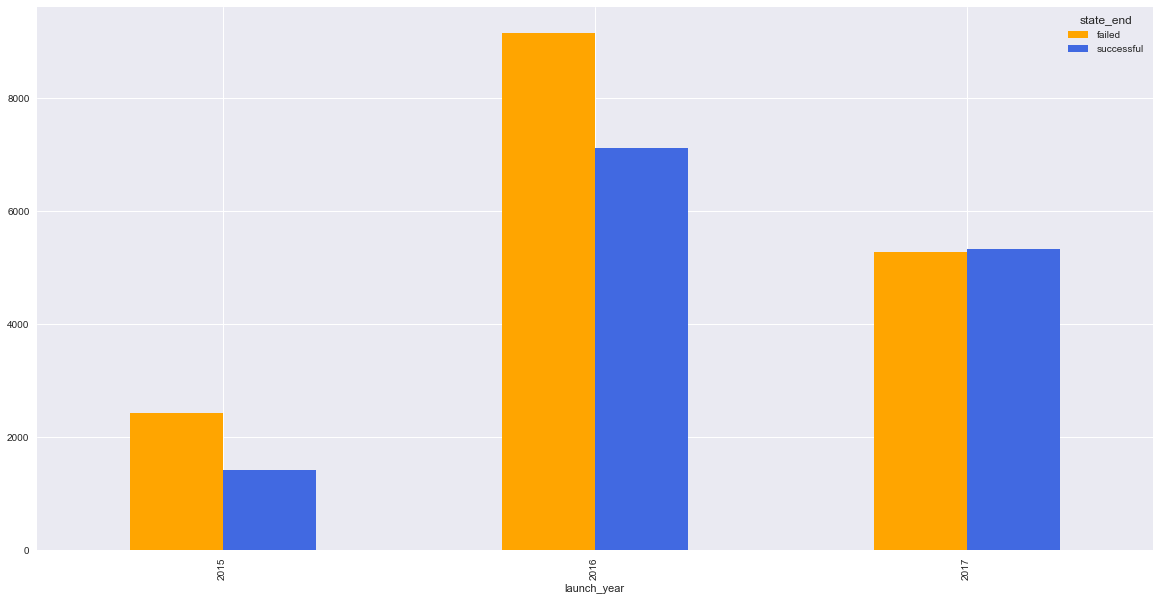

In [161]:
pd.crosstab(index=df['launch_year'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.2 month

In [162]:
df['launch_month'] = df['launch_datetime'].dt.month

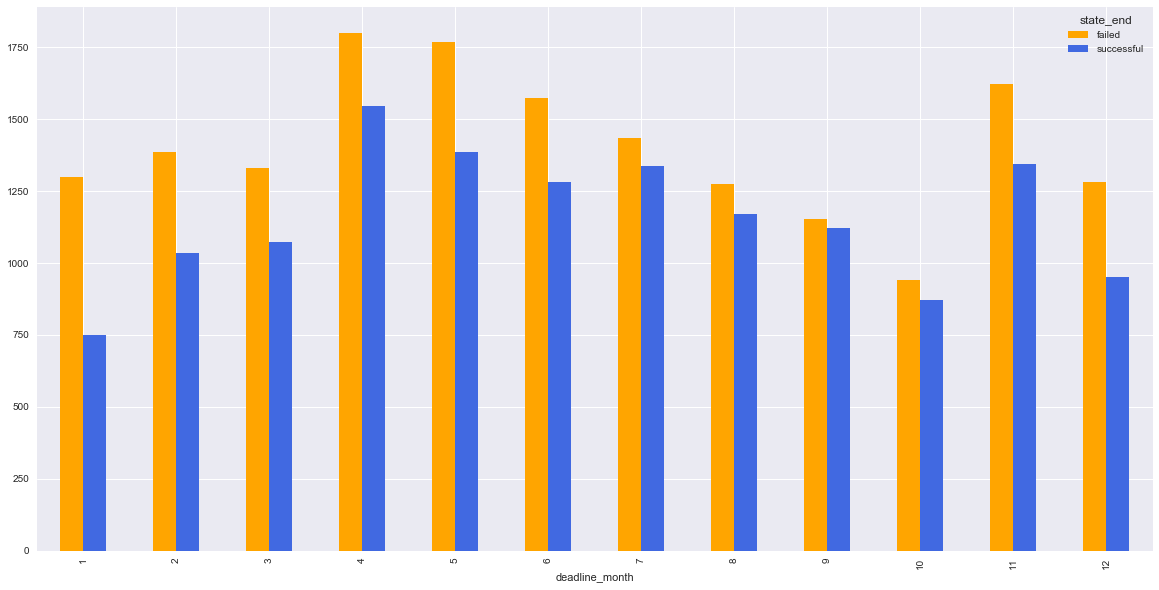

In [163]:
pd.crosstab(index=df['deadline_month'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.3 day

In [164]:
df['launch_day'] = df['launch_datetime'].dt.day

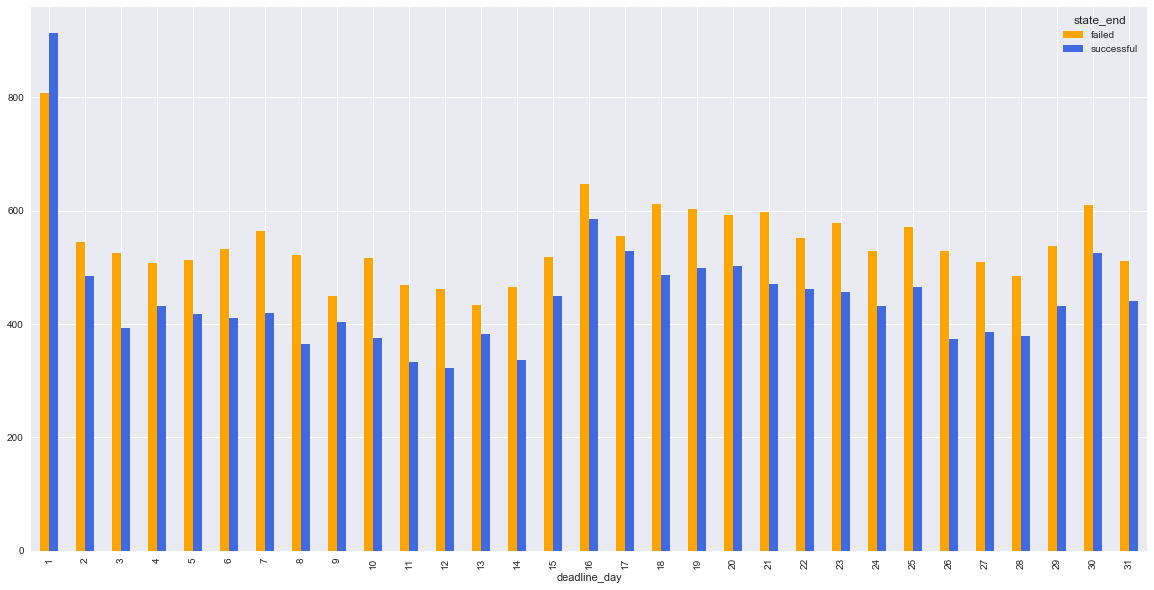

In [165]:
pd.crosstab(index=df['deadline_day'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.4 day of week

In [166]:
df['launch_dayofweek'] = df['launch_datetime'].dt.dayofweek

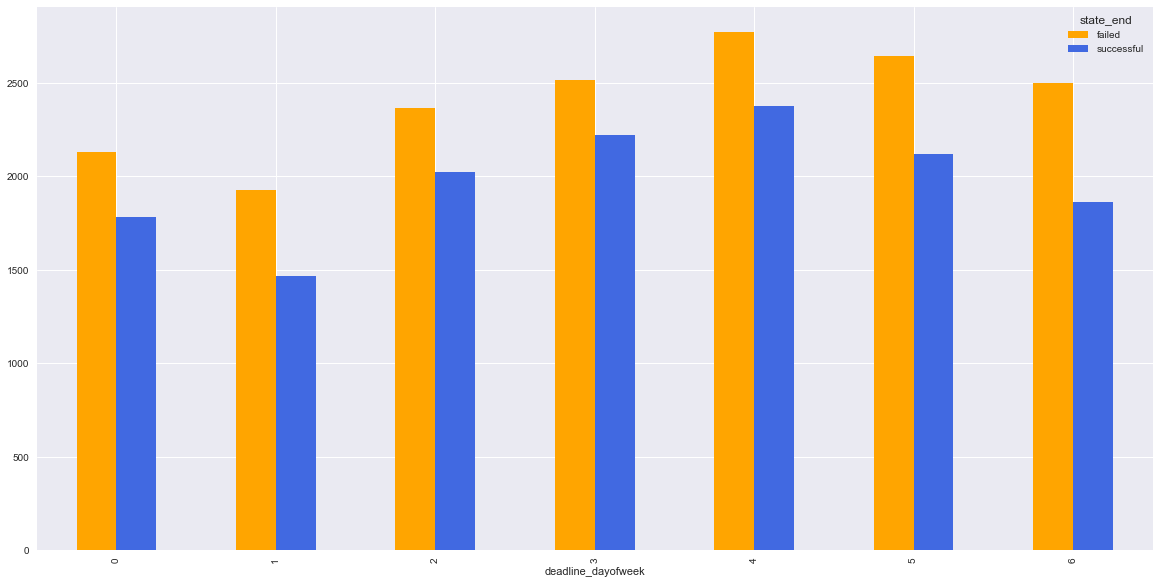

In [167]:
pd.crosstab(index=df['deadline_dayofweek'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.5 hour

In [168]:
df['launch_hour'] = df['launch_datetime'].dt.hour

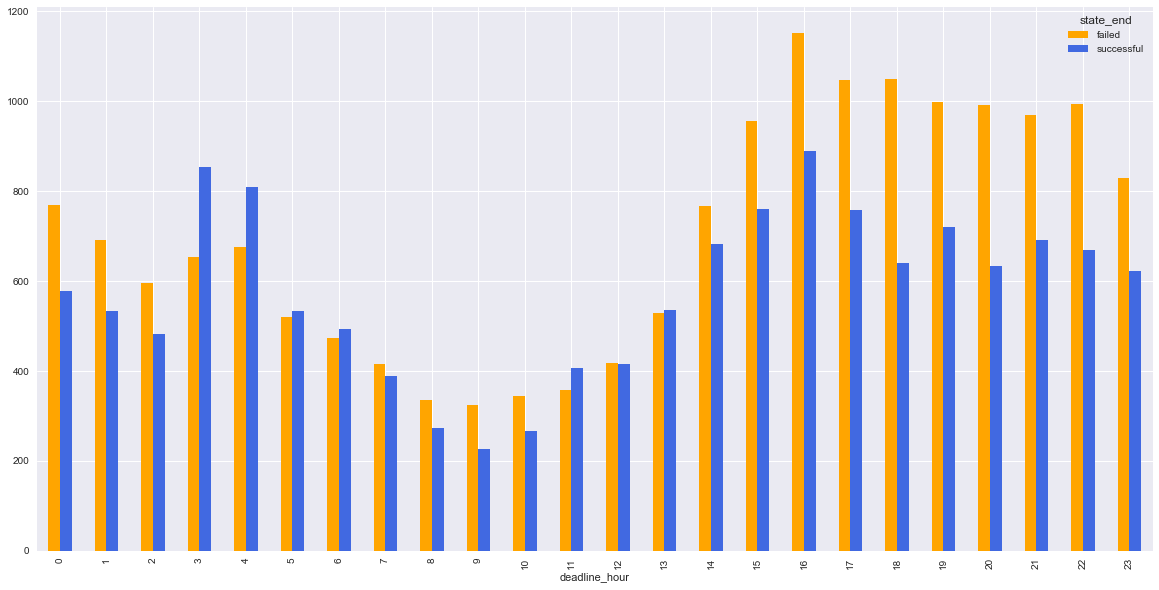

In [169]:
pd.crosstab(index=df['deadline_hour'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

### 3. facebook shares

In [170]:
plt.rcParams['figure.figsize'] = (20,10)

In [171]:
df['db_fb_shares_count'].describe()

count     30702.000000
mean        382.737411
std        1825.706968
min           0.000000
25%           9.000000
50%          77.000000
75%         290.000000
max      108071.000000
Name: db_fb_shares_count, dtype: float64

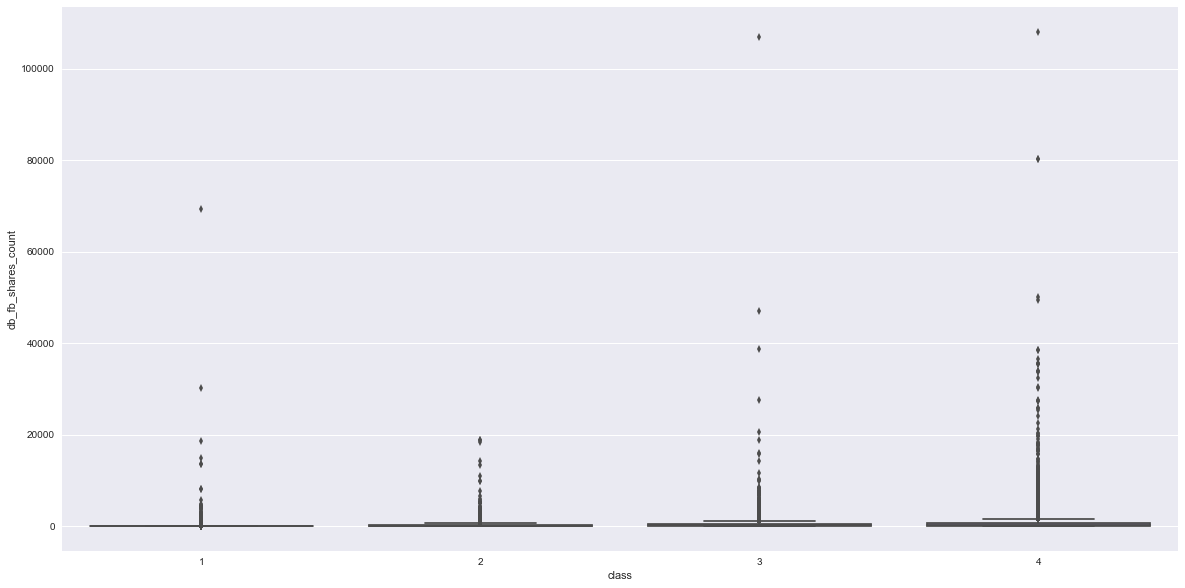

In [172]:
sns.boxplot(data=df, y='db_fb_shares_count', x='class')

(-100, 1600)

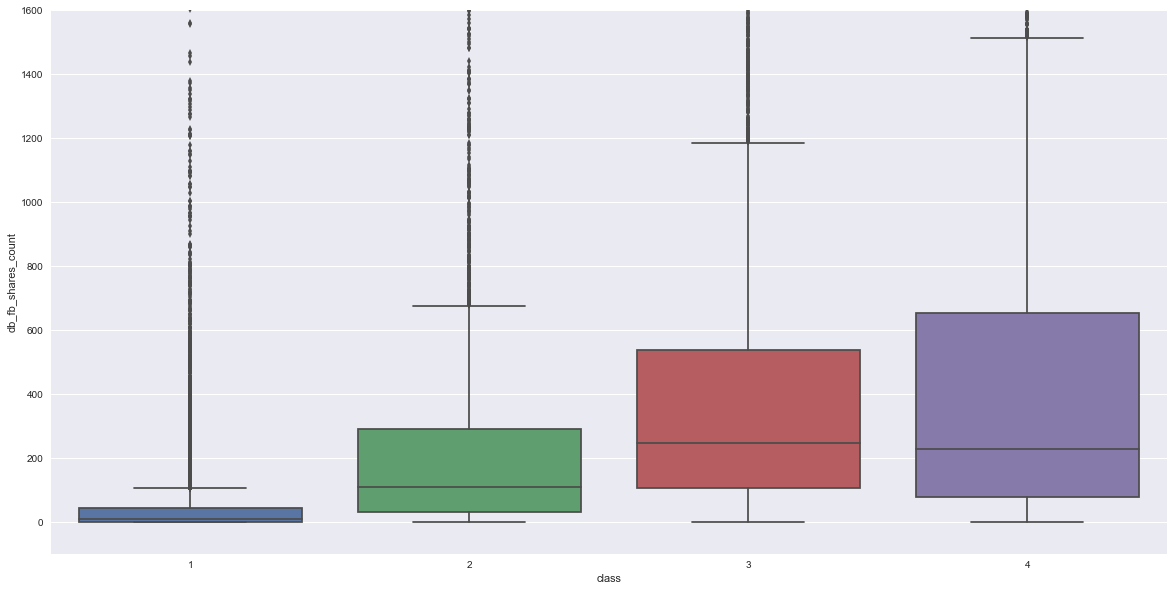

In [173]:
sns.boxplot(data=df, y='db_fb_shares_count', x='class')
plt.ylim((-100,1600))

In [174]:
df.corr()['db_fb_shares_count'].abs().sort_values(ascending=False)

db_fb_shares_count                       1.000000
usd_pledged_end                          0.532433
pledged_end                              0.476600
db_pledged                               0.476600
usd_pledged                              0.475299
backers_count_end                        0.455001
pledged                                  0.435585
db_comments_count                        0.425622
backers_count                            0.415224
updates_likes_max_while_scraping         0.363069
updates_likes_sum_while_scraping         0.359394
updates_likes_mean_while_scraping        0.352924
updates_likes_median_while_scraping      0.343648
comments_count_public_while_scraping     0.336174
comments_count_creator_while_scraping    0.316102
updates_likes_min_while_scraping         0.286362
db_faq_count                             0.263134
ratio_pledged_end_goal                   0.239336
db_updates_count                         0.236754
faq_count_while_scraping                 0.232721


Pearson correlation: 0.532


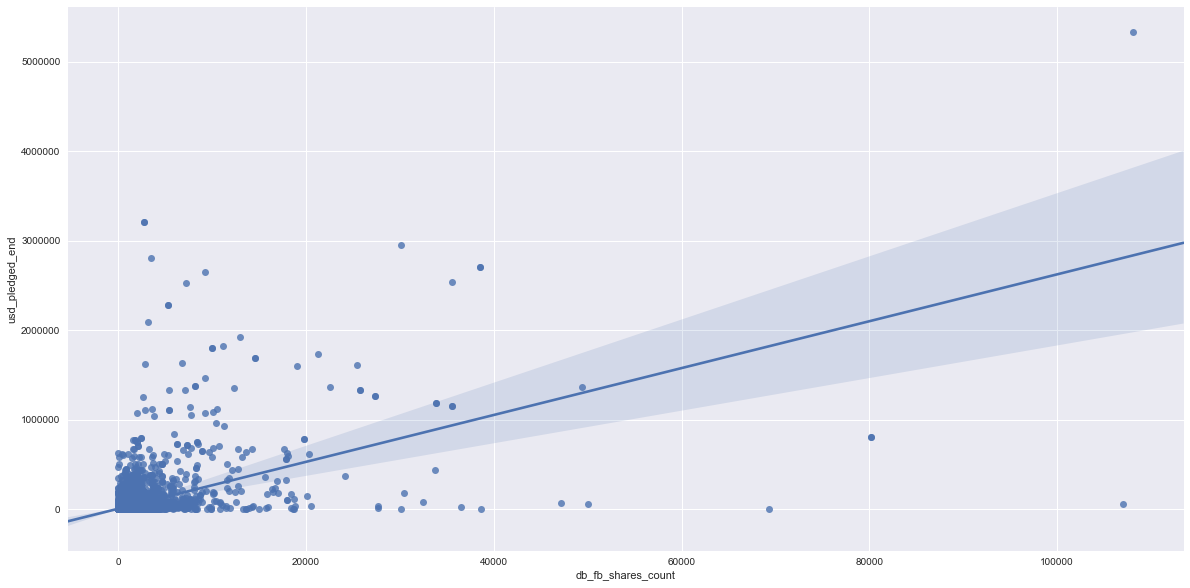

In [175]:
attr = 'usd_pledged_end' 
sns.regplot(x="db_fb_shares_count", y=attr, data=df)
print("Pearson correlation: %.3f" % df['db_fb_shares_count'].corr(df[attr]))

In [176]:
df[df.db_fb_shares_count > 60000]['url_name']

8859           udoo-x86-the-most-powerful-maker-board-ever
8860           udoo-x86-the-most-powerful-maker-board-ever
18063                      scream-a-new-beginning-fan-film
19863          tenkiv-nexus-solving-the-clean-water-crisis
23745    zetime-worlds-first-smartwatch-with-hands-over...
Name: url_name, dtype: object

### 4. count of images

In [177]:
df['image_count'] = df['db_description_full'].apply(lambda x: str(x).count('<img'))

In [178]:
df['image_count'].value_counts()

0      12543
3       1428
1       1410
4       1340
5       1240
2       1224
6       1106
7        927
8        833
9        761
10       701
11       550
12       540
13       472
14       420
15       390
16       369
18       306
17       287
19       273
20       249
21       232
22       213
24       200
23       193
26       165
25       160
27       145
28       130
29       122
       ...  
81         5
78         4
92         4
96         4
83         4
72         3
75         3
100        3
69         3
103        3
86         3
79         2
76         2
98         2
84         2
90         2
87         2
94         1
77         1
102        1
112        1
88         1
91         1
115        1
120        1
106        1
185        1
89         1
82         1
99         1
Name: image_count, Length: 103, dtype: int64

In [179]:
df[df['image_count'] > 150][['url_name', 'image_count']]

,url_name,image_count
19800,the-worlds-smartest-modular-wifi-bluetooth-wea...,185


In [180]:
static_data.append('image_count')

### 5. count of videos

#### 5.1 kickstarter videos

In [181]:
df['video_kickstarter_count'] = df['db_description_full'].apply(lambda x: str(x).count('<video'))

In [182]:
df['video_kickstarter_count'].value_counts()

0     28166
1      1461
2       537
3       208
4       156
5        64
6        43
7        34
8        14
9         8
11        4
12        3
10        3
13        1
Name: video_kickstarter_count, dtype: int64

In [183]:
static_data.append('video_kickstarter_count')

#### 5.2 youtube videos

In [184]:
df['video_youtube_count'] = df['db_description_full'].apply(lambda x: str(x).count('src="https://www.youtube.com/embed/'))

In [185]:
df['video_youtube_count'].value_counts()

0     28462
1      1266
2       422
3       231
4       145
5        80
6        42
7        14
8        11
10        7
11        6
12        5
9         4
17        2
13        2
14        1
16        1
15        1
Name: video_youtube_count, dtype: int64

In [186]:
df[df['video_youtube_count'] > 15]['url_name']

1728                      the-wearable-camera-for-athletes
1789     7bot-a-powerful-desktop-robot-arm-for-future-i...
16299    fizzics-waytap-untap-the-full-taste-of-beer-wi...
Name: url_name, dtype: object

In [187]:
static_data.append('video_youtube_count')

#### 5.3 videos total (kickstarter + youtube)

In [188]:
df['video_count'] = df['video_kickstarter_count'] + df['video_youtube_count']

In [189]:
df['video_count'].value_counts()

0     26310
1      2305
2       907
3       457
4       322
5       163
6       100
7        37
8        29
9        24
10       16
11       11
13        9
12        7
16        2
19        1
17        1
14        1
Name: video_count, dtype: int64

In [190]:
static_data.append('video_count')

### 6. count of audio

In [191]:
df['audio_count'] = df['db_description_full'].apply(lambda x: str(x).count('<audio'))

In [192]:
df['audio_count'].value_counts()

0     30299
1       254
2        64
3        47
4        16
5         8
6         5
7         4
8         2
11        1
10        1
9         1
Name: audio_count, dtype: int64

In [193]:
df[df['audio_count'] > 10]['url_name']

20143    professor-grownup-cthulhu-album-for-kids
Name: url_name, dtype: object

In [194]:
static_data.append('audio_count')

### 7. other embeded content

In [195]:
# can be literally anything - video, playlist, etc.
df['other_embeded_count'] = df['db_description_full'].apply(lambda x: str(x).count('<iframe'))

In [196]:
df['other_embeded_count'] = (df['other_embeded_count'] - df['video_youtube_count'])

In [197]:
df['other_embeded_count'].value_counts()

 0     29891
 1       536
 2       138
 3        61
 4        20
 5        18
 6        15
 8         7
 7         5
 10        3
 9         3
 12        2
 22        2
-1         1
Name: other_embeded_count, dtype: int64

In [198]:
df[df['other_embeded_count'] < 0]['url_name']

1003    brad-jurjens-first-solo-album
Name: url_name, dtype: object

In [199]:
# there is no other embeded content - author did not use iframe as expected
df.loc[1003, 'other_embeded_count'] = 0

In [200]:
static_data.append('other_embeded_count')

## Feature transformation

### 1. db_image_url

Transform as follows:
* 0 where url is missing
* 1 otherwise

In [201]:
df.db_image_url.describe()

count                                                 21414
unique                                                18820
top       https://ksr-ugc.imgix.net/assets/012/412/223/7...
freq                                                      3
Name: db_image_url, dtype: object

In [202]:
df.db_image_url.fillna(0, inplace=True)

In [203]:
df.db_image_url = df.db_image_url.apply(lambda x: int(len(str(x)) > 1))

In [204]:
df.rename(index=str, columns={"db_image_url": "db_image"}, inplace=True)

In [205]:
df.db_image.value_counts()

1    21414
0     9288
Name: db_image, dtype: int64

In [206]:
static_data.remove('db_image_url')
#static_data.append('db_image')

In [207]:
# wrong
df[(df['db_image'] == 0) & (df['image_count'] !=0)]['url_name']

10                                                designed
32         the-hue-colorlink-the-color-wheel-of-the-future
43                            cairo-tattoo-convention-2015
61                                 ggs-launch-to-animation
62                       vellebe-ink-tattoos-and-piercings
64                                   life-size-maze-puzzle
81                                       nomi-get-drawn-in
94               3-pixel-and-bead-crafts-sprites-for-all-0
96             vudu-tarot-afro-caribbean-art-in-your-hands
97                 game-and-digital-art-museum-and-gallery
122      landscape-ring-with-six-stones-its-really-beau...
125         the-wren-windsong-an-interactive-bonsai-studio
127                                bodies-create-sculpture
129                     maui-trapeze-flying-trapeze-school
131               our-gift-for-the-future-canada-1867-2017
135      faux-fest-the-greatest-music-festival-you-neve...
145                            artworks-beautify-the-pla

### 2. db_video_url

Transform as follows:
* 0 where url is missing
* 1 otherwise

In [208]:
df.db_video_url.describe()

count                                                 20443
unique                                                17985
top       https://ksr-video.imgix.net/projects/2377843/v...
freq                                                      3
Name: db_video_url, dtype: object

In [209]:
df.db_video_url.fillna(0, inplace=True)

In [210]:
df.db_video_url = df.db_video_url.apply(lambda x: int(len(str(x)) > 1))

In [211]:
df.rename(index=str, columns={"db_video_url": "db_video"}, inplace=True)

In [212]:
df.db_video.value_counts()

1    20443
0    10259
Name: db_video, dtype: int64

In [213]:
static_data.remove('db_video_url')
#static_data.append('db_video')

### 3. Categorical encoding

In [214]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30702 entries, 0 to 30701
Data columns (total 24 columns):
blurb                      30702 non-null object
category_name              30702 non-null object
category_parent            30702 non-null object
category_position          30702 non-null int64
country                    30702 non-null object
currency                   30702 non-null object
days_duration              30702 non-null int64
days_preparation           30702 non-null int64
db_description_full        30691 non-null object
db_duration                30702 non-null int64
deadline_end               30702 non-null int64
goal                       30702 non-null float64
launched_at                30702 non-null int64
location_name              30702 non-null object
location_state             30702 non-null object
location_type              30702 non-null object
usd_goal                   30702 non-null int64
class                      30702 non-null int64
image_count          

In [215]:
data_to_encode = [
    'category_name',
    'category_parent',
    'country',
    'currency',
    'location_name',
    'location_state',
    'location_type',
]
encoded = []

In [216]:
for column in data_to_encode:
    print(column, len(df[column].value_counts()), 'distinct values')
    encoder = ce.OrdinalEncoder()
    df[column+'_num'] = encoder.fit_transform(df[[column]])
    encoded.append(column+'_num')

category_name 141 distinct values
category_parent 15 distinct values
country 22 distinct values
currency 14 distinct values
location_name 4705 distinct values
location_state 609 distinct values
location_type 9 distinct values


In [217]:
df[encoded].describe()

,category_name_num,category_parent_num,country_num,currency_num,location_name_num,location_state_num,location_type_num
count,30702.000000,30702.000000,30702.000000,30702.000000,30702.000000,30702.000000,30702.000000
mean,59.717966,7.353169,2.274901,1.174679,850.636506,53.237053,0.240212
std,33.200639,3.909349,4.334961,2.340555,1133.612406,83.413457,0.876933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,4.000000,0.000000,0.000000,84.000000,9.000000,0.000000
50%,59.000000,8.000000,0.000000,0.000000,307.000000,22.000000,0.000000
75%,89.000000,11.000000,3.000000,1.000000,1163.000000,61.000000,0.000000
max,140.000000,14.000000,21.000000,13.000000,4704.000000,608.000000,8.000000


In [218]:
enc = preprocessing.OneHotEncoder()
enc.fit(df[encoded])

# count of distinct values per each column
enc.n_values_

array([ 141,   15,   22,   14, 4705,  609,    9])

In [219]:
# index borders
enc.feature_indices_

array([   0,  141,  156,  178,  192, 4897, 5506, 5515], dtype=int32)

In [220]:
df_encoded_categorical = pd.DataFrame(enc.transform(df[encoded]).toarray())
df_encoded_categorical.head()

,0,1,2,3,4,5,6,7,8,9,...,5505,5506,5507,5508,5509,5510,5511,5512,5513,5514
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature selection

apply PCA to df_encoded_categorical or its subparts?

vs. to whole feature vector?

In [221]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30702 entries, 0 to 30701
Data columns (total 24 columns):
blurb                      30702 non-null object
category_name              30702 non-null object
category_parent            30702 non-null object
category_position          30702 non-null int64
country                    30702 non-null object
currency                   30702 non-null object
days_duration              30702 non-null int64
days_preparation           30702 non-null int64
db_description_full        30691 non-null object
db_duration                30702 non-null int64
deadline_end               30702 non-null int64
goal                       30702 non-null float64
launched_at                30702 non-null int64
location_name              30702 non-null object
location_state             30702 non-null object
location_type              30702 non-null object
usd_goal                   30702 non-null int64
class                      30702 non-null int64
image_count          

In [222]:
df_static = df[static_data].select_dtypes(exclude=['object']).drop(['deadline_end', 'launched_at'], axis=1)

In [223]:
# change index types
df_encoded_categorical.index = df_encoded_categorical.index.astype('int64')
df_static.index = df_static.index.astype('int64')

In [224]:
df_static = df_static.join(df_encoded_categorical)

In [225]:
df_static.to_csv('data/static_01.csv')